frame, chirp_loop, chirp =  79  ,  13  ,  1 



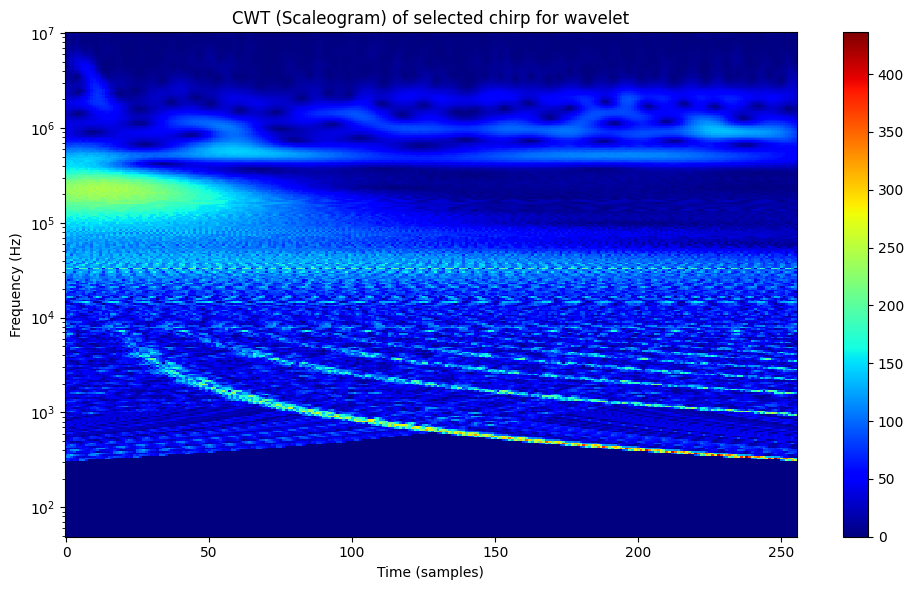

frame, chirp_loop, chirp =  79  ,  13  ,  2 



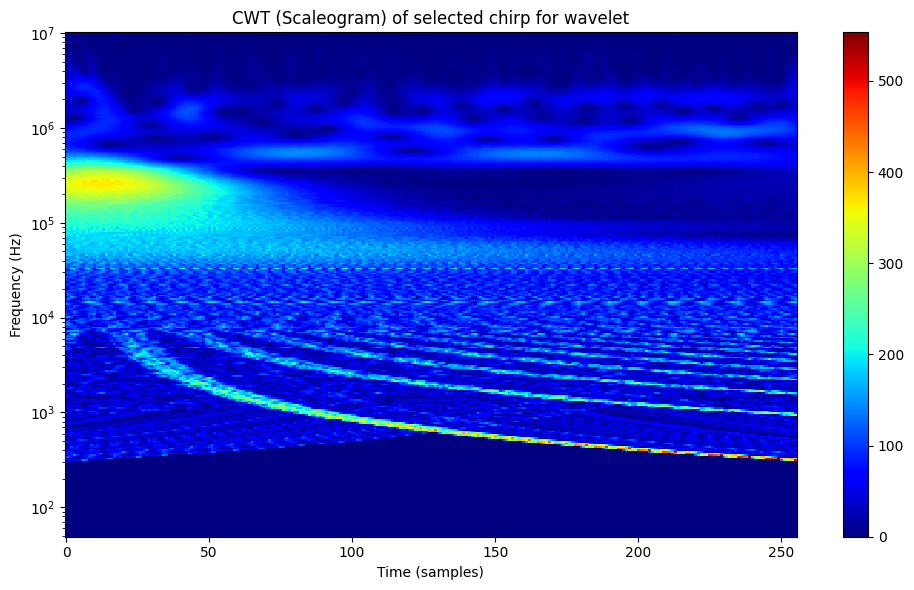

frame, chirp_loop, chirp =  79  ,  13  ,  3 



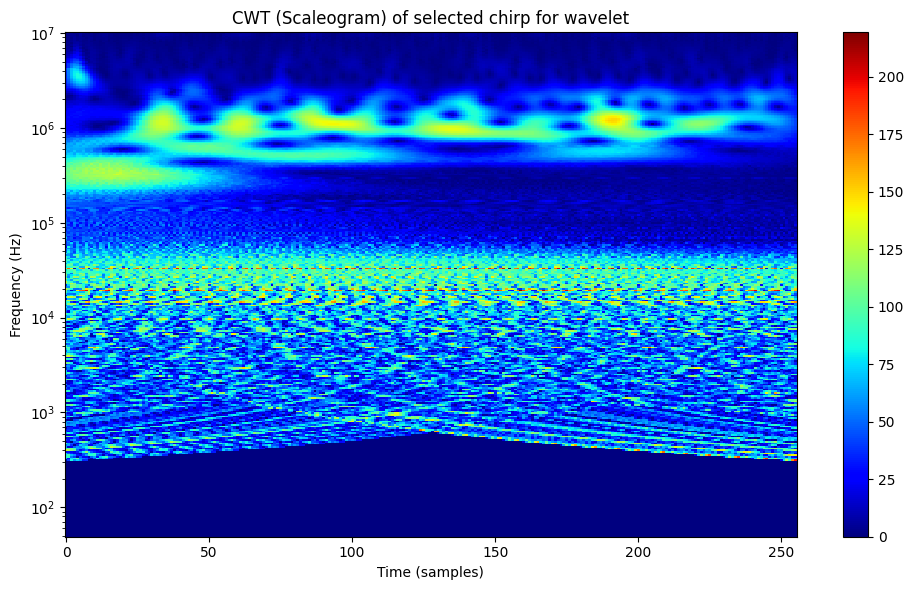

frame, chirp_loop, chirp =  79  ,  13  ,  4 



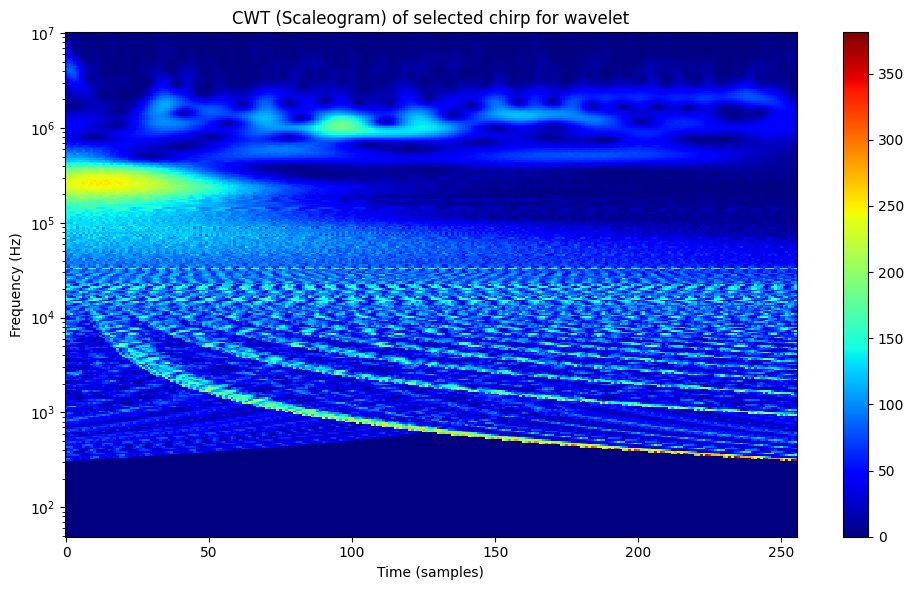

frame, chirp_loop, chirp =  79  ,  13  ,  5 



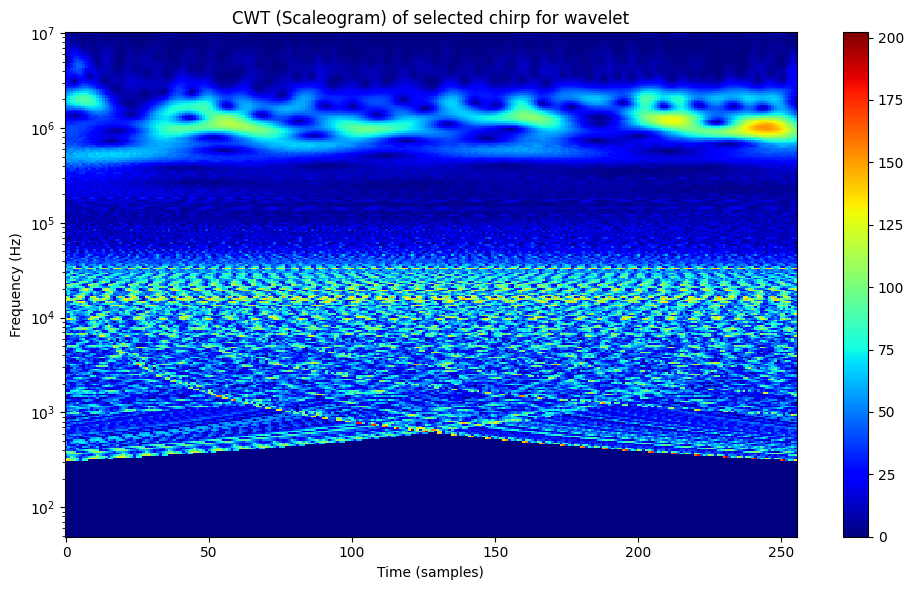

frame, chirp_loop, chirp =  79  ,  13  ,  6 



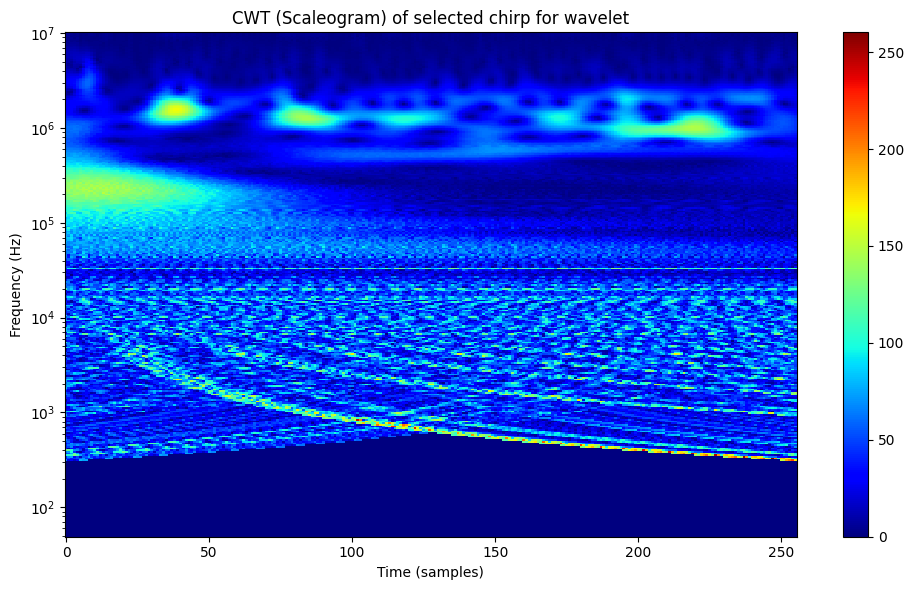

frame, chirp_loop, chirp =  79  ,  13  ,  7 



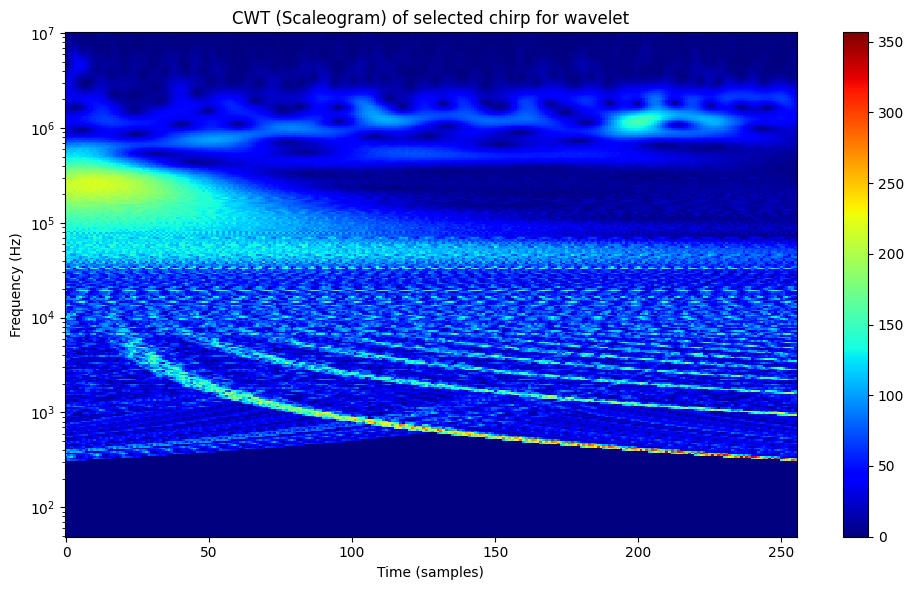

frame, chirp_loop, chirp =  79  ,  13  ,  8 



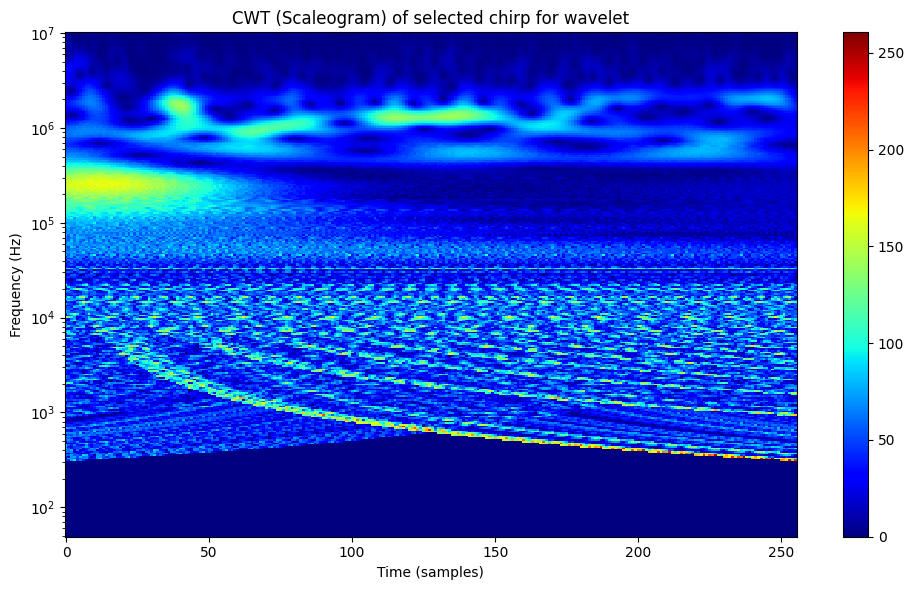

frame, chirp_loop, chirp =  79  ,  13  ,  9 



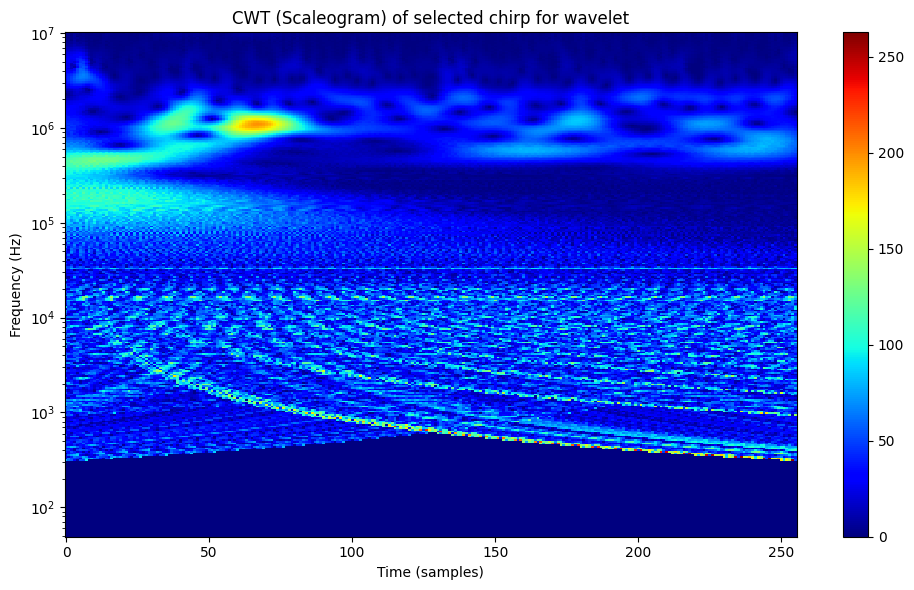

frame, chirp_loop, chirp =  79  ,  13  ,  10 



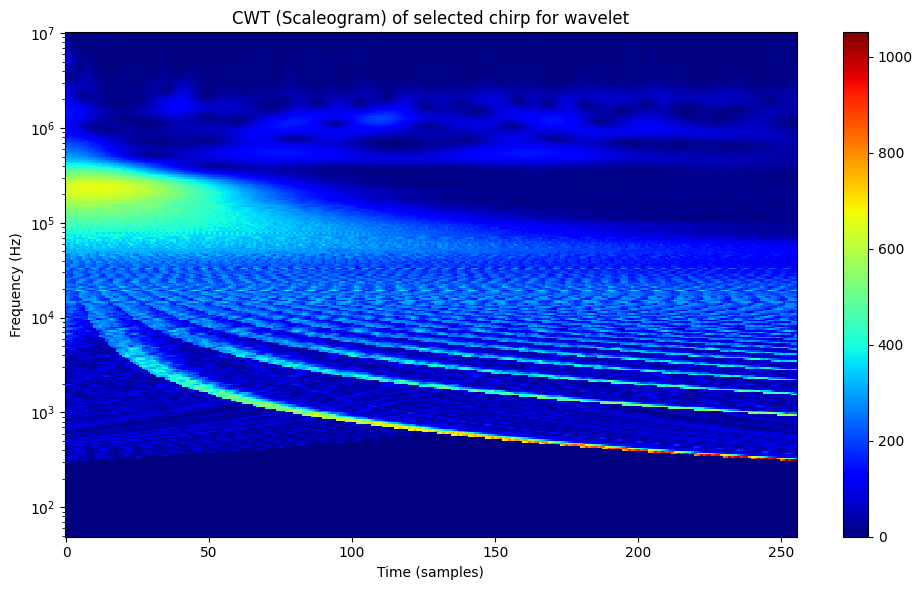

frame, chirp_loop, chirp =  79  ,  13  ,  11 



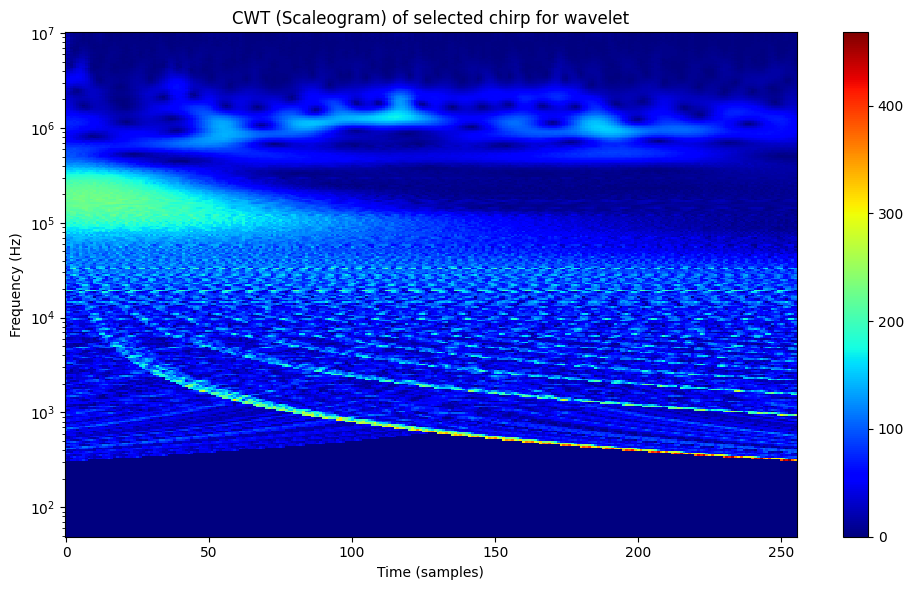

frame, chirp_loop, chirp =  79  ,  13  ,  12 



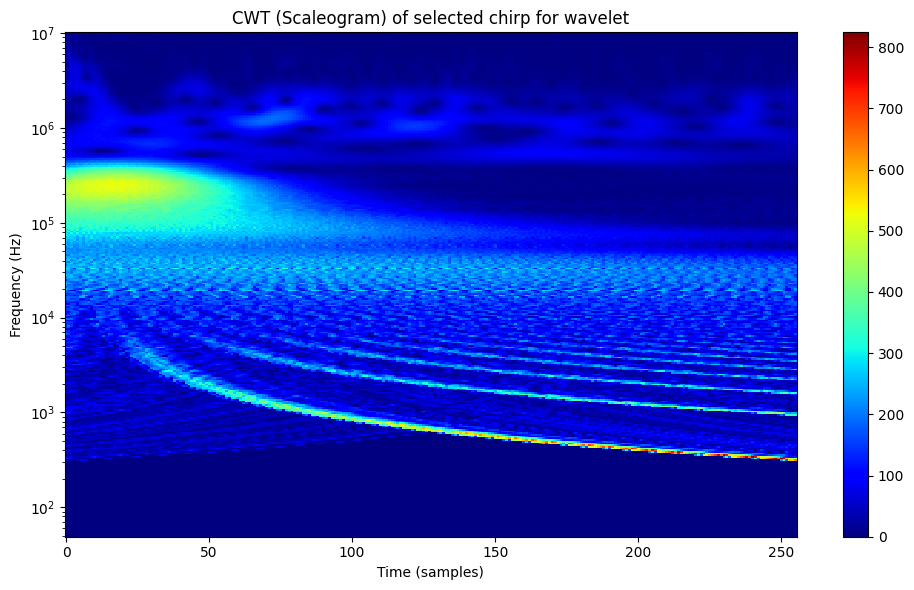

In [12]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pywt
from scipy.signal import butter, filtfilt
import os  # To handle file paths

# Define the save directory and base filename
save_directory = r'D:\FYP-SignalProcessing\scalograms'
base_filename = 'scalograms'

# Ensure the save directory exists
os.makedirs(save_directory, exist_ok=True)


for frame_index  in range(78,79,1):
    for chirp_loop_index  in range(12,13,1):
        for chirp_index in range(0,12,1):
            # Define file path and parameters
            fileFullPath = r'E:\Data_Set\new_Data_for_dr_madanayaka\drone_rotated_02\master_0000_data.bin';
            frameIdx = frame_index# Index of the frame to read
            numSamplePerChirp = 256  # Number of samples per chirp
            numChirpPerLoop = 12  # Number of chirps per loop
            numLoops = 128 # Number of loops per frame
            numRXPerDevice = 4  # Number of receiving channels per device
            numDevices = 4  # Number of devices in the cascade (if needed)

            # Function to read binary radar data
            def readBinFile(fileFullPath, frameIdx, numSamplePerChirp, numChirpPerLoop, numLoops, numRXPerDevice):
                Expected_Num_SamplesPerFrame = numSamplePerChirp * numChirpPerLoop * numLoops * numRXPerDevice * 2
                with open(fileFullPath, 'rb') as fp:
                    # Move to the desired frame in the file
                    fp.seek((frameIdx - 1) * Expected_Num_SamplesPerFrame * 2)
                    adcData1 = np.fromfile(fp, dtype=np.uint16, count=Expected_Num_SamplesPerFrame)

                # Convert the 16-bit data to signed integers
                neg = (adcData1 >> 15) == 1  # Check the sign bit
                adcData1 = adcData1.astype(np.int32)
                adcData1[neg] -= 2**16

                # Combine the I and Q channels into complex values
                adcData1 = adcData1[0::2] + 1j * adcData1[1::2]

                # Reshape and permute the data
                adcData1Complex = np.reshape(adcData1, (numRXPerDevice, numSamplePerChirp, numChirpPerLoop, numLoops), order='F')
                adcData1Complex = np.transpose(adcData1Complex, (1, 3, 0, 2))  # Permute dimensions
                return adcData1Complex

            # Read radar data
            adcDataComplex = readBinFile(fileFullPath, frameIdx, numSamplePerChirp, numChirpPerLoop, numLoops, numRXPerDevice)

            # Select antenna index and extract chirp ADC matrix
            antennaIdx = 3 # Indexing starts from 0 in Python
            chirp_ADC_matrix = adcDataComplex[:, :, antennaIdx, :]

            # Extract first chirp of the first loop
            Aimed_chirp_for_wavelet = chirp_ADC_matrix[:, chirp_loop_index, chirp_index]
            # print("chirp_ADC_matrix shape" ,chirp_ADC_matrix.shape)
            # print("\n")
            print("frame, chirp_loop, chirp = ",frame_index+1, " , ", chirp_loop_index+1, " , " , chirp_index+1,"\n")

            # perform CWT
            wavelet = "cmor1.5-1.0"
            # logarithmic scale for scales, as suggested by Torrence & Compo:
            widths = np.geomspace(1, 200000, num=300)
            time_sampled = np.arange(256)
            # Apply CWT on the sampled chirp signal
            cwtmatr, freqs_new = pywt.cwt(Aimed_chirp_for_wavelet, widths, wavelet, sampling_period=1/1e7 )
            # Take absolute value of complex result
            cwtmatr = np.abs(cwtmatr)

            # print("Frequency values (Hz):")
            # print(freqs_new)
            # print("\n")

            # Plot the scaleogram (CWT result)
            plt.figure(figsize=(10, 6))
            pcm = plt.pcolormesh(time_sampled, freqs_new, cwtmatr, shading='auto', cmap='jet')
            plt.yscale("log")
            # # Set frequency axis limits to 0 Hz to 800 Hz
            # plt.ylim(55, 555)  # Limiting y-axis (frequency) from 0 to 800 Hz
            plt.xlabel("Time (samples)")
            plt.ylabel("Frequency (Hz)")
            plt.title(f"CWT (Scaleogram) of selected chirp for wavelet")
            plt.colorbar(pcm)
            plt.tight_layout()

            # Save the figure
            save_path = os.path.join(save_directory, f'{base_filename}_frame_{frame_index+1}_chirp-loop_{chirp_loop_index+1}_chirp_{chirp_index+1}.png')
            plt.savefig(save_path)

            plt.show()
            plt.close()  # Close the figure to avoid displaying it repeatedly